In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau  # add import
from torchvision.transforms import v2 as T
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from ShroomDataset import ShroomDataset, HierSupConLoss, ContrastiveWrapper, TwoCropsTransform, HierBatchSampler
from ShroomCNN import ShroomCNNAttentive, AuxSpeciesHead
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, top_k_accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from PIL import Image, ImageOps
import os
from tqdm.auto import tqdm
from contextlib import nullcontext

data_path = './data/'

train_meta = pd.read_csv(os.path.join(data_path, 'train.csv'))#.iloc[:1000]
val_meta = pd.read_csv(os.path.join(data_path, 'val.csv'))
test_meta = pd.read_csv(os.path.join(data_path, 'test.csv'))


In [2]:

# def compute_mean_std(df, base_path, sample=20000, size=256, num_workers=6, batch_size=256):
#     # sample for speed (use all rows if df is small)
#     if len(df) > sample:
#         df = df.sample(n=sample, random_state=0).reset_index(drop=True)
#     tf = T.Compose([
#         T.Resize(size, antialias=False),
#         T.CenterCrop(size),
#         T.ToDtype(torch.float32, scale=True)
#     ])
#     ds = ShroomDataset(df, base_path, transform=tf, label2idx=None)
#     loader = DataLoader(ds, batch_size=batch_size, shuffle=False,
#                         num_workers=num_workers, pin_memory=False)
#     m = torch.zeros(3); s2 = torch.zeros(3); n=0
#     for x, _ in tqdm(loader, desc="Compute mean/std"):
#         b,c,h,w = x.shape
#         x = x.view(b, c, -1)
#         m  += x.mean(dim=(0,2)) * b
#         s2 += x.var (dim=(0,2), unbiased=False) * b
#         n  += b
#     mean = (m/n).tolist()
#     std  = (s2/n).sqrt().tolist()
#     return tuple(mean), tuple(std)

# # One-time compute:
# mean, std = compute_mean_std(train_meta, data_path, sample=700000, size=256, num_workers=6)
# print("DATASET mean/std:", mean, std)

In [ ]:
IMGc = 172
# dataset statistics
mean = (0.43458297848701477, 0.40228864550590515, 0.332194983959198)
std  = (0.25477853417396545, 0.24025271832942963, 0.2363586127758026)

heavy_geom = T.Compose([
    T.RandomResizedCrop(IMGc, scale=(0.65, 1.0), ratio=(0.80, 1.25), antialias=False),
    T.RandomAffine(degrees=7, translate=(0.05, 0.05), scale=(0.97, 1.03)),
])

light_view = T.Compose([
    T.RandomHorizontalFlip(0.5),
    T.RandomVerticalFlip(0.1),
    T.RandomApply([T.ColorJitter(0.15, 0.15, 0.15, 0.04)], p=0.4),
    T.RandomGrayscale(p=0.08),
    T.RandomApply([T.GaussianBlur(kernel_size=3)], p=0.05),
    T.ToDtype(torch.float32, scale=True),
    T.Normalize(mean, std),
])



In [ ]:
# base dataset
cont_base = ShroomDataset(train_meta, data_path, transform=None, cache=False)
# contrastive wrapper
cont_ds   = ContrastiveWrapper(cont_base, TwoCropsTransform(heavy_geom, light_view))

num_classes = len(cont_ds.base.label2idx)
train_labels = np.asarray(cont_ds.base.labels, dtype=np.int64)
idx2label = {v: k for k,v in cont_ds.base.label2idx.items()}
# frequency-based weights (inverse freq)
counts = np.bincount(train_labels, minlength=num_classes)
# alpha is the smoothing factor
alpha = 0.5  # try 0.3–0.7
class_w = (np.maximum(counts, 1) ** -alpha)
sample_w = class_w[train_labels]

# Build a consistent mapping: species_id -> genus_id
species_names = list(cont_ds.base.label2idx.keys())          # unique species names
genus2idx = {g:i for i,g in enumerate(sorted({s.split()[0] for s in species_names}))}

num_species = len(species_names)
species_to_genus = torch.empty(num_species, dtype=torch.long)
for sp_name, sp_id in cont_ds.base.label2idx.items():
    g_id = genus2idx[sp_name.split()[0]]
    species_to_genus[sp_id] = g_id

per_sample_genus = np.asarray([int(species_to_genus[sp]) for sp in cont_ds.base.labels],
                              dtype=np.int64)
NUM_WORKERS = min(8, max(1, (os.cpu_count() or 4) // 2))
print(f"Using {NUM_WORKERS} workers")

# Build the base hierarchical sampler
hb_sampler = HierBatchSampler(
    cont_ds.base.labels,
    per_sample_genus,
    n_genus=24, species_per_genus=3, imgs_per_species=2,
    steps=1500
)

dl_kwargs = dict(
    batch_sampler=hb_sampler,
    num_workers=NUM_WORKERS,
    persistent_workers=(NUM_WORKERS > 0),
    pin_memory=torch.cuda.is_available(),
)
if NUM_WORKERS > 0:
    dl_kwargs["prefetch_factor"] = 2  # 2 batches per worker

cont_loader = DataLoader(cont_ds, **dl_kwargs)

Using 6 workers


In [ ]:
class EncoderFromBackbone(nn.Module):
    def __init__(self, backbone: nn.Module, feat_bn: bool = True):
        super().__init__()
        self.stem = getattr(backbone, 'stem', nn.Identity())
        self.body = backbone.model
        self.pool = backbone.global_pool
        self.flatten = nn.Flatten()

        # Prefer feature dim provided by backbone; fallback to first Linear in classifier.
        out_dim = getattr(backbone, 'feat_dim', None)
        if out_dim is None:
            first_linear = None
            for m in getattr(backbone, 'classifier', []):
                if isinstance(m, nn.Linear):
                    first_linear = m
                    break
            assert first_linear is not None, "Couldn't infer feature dim: set backbone.feat_dim or start classifier with a Linear."
            out_dim = first_linear.in_features

        self.out_dim = int(out_dim)
        self.bn = nn.BatchNorm1d(self.out_dim) if feat_bn else nn.Identity()

    def forward(self, x):
        x = self.stem(x)
        x = self.body(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = x.contiguous()
        x = self.bn(x)
        return x

class ProjectionMLP(nn.Module):
    def __init__(self, in_dim, hid=512, out_dim=256, use_bn=True):
        super().__init__()
        layers = [nn.Linear(in_dim, hid)]
        if use_bn:
            layers.append(nn.BatchNorm1d(hid))
        layers += [nn.ReLU(inplace=True), nn.Linear(hid, out_dim)]
        # final BN without affine keeps scale/shift inside normalize
        if use_bn:
            layers.append(nn.BatchNorm1d(out_dim, affine=False))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = x.contiguous()
        x = self.net(x)
        return F.normalize(x, dim=1, eps=1e-8)


In [ ]:
class SupConLoss(nn.Module):
    """ deprecated, use hier sup con loss"""
    def __init__(self, temperature=0.07):
        super().__init__()
        self.t = float(temperature)

    def forward(self, z, y):
        """
        z: [B, 2, D] 
        y: [B]
        """
        device = z.device
        B, V, D = z.shape

    
        if z.dtype != torch.float32:
            z = z.float()

        z = z.reshape(B * V, D).contiguous()

        # similarities / temperature
        logits = torch.matmul(z, z.T) / self.t
        logits = torch.nan_to_num(logits, nan=0.0, posinf=1e4, neginf=-1e4)

        # mask self and stabilize
        self_mask = torch.eye(B * V, device=device, dtype=torch.bool)
        logits = logits.masked_fill(self_mask, float("-inf"))

        # subtract per-row max (guard rows that are all -inf)
        row_max = logits.max(dim=1, keepdim=True).values
        row_max = torch.where(torch.isfinite(row_max), row_max, torch.zeros_like(row_max))
        logits = logits - row_max
        logits = torch.nan_to_num(logits, nan=0.0, posinf=1e4, neginf=-1e4)

        # positives mask across views
        y = y.reshape(B, 1)
        pos = (y == y.T)
        pos = pos.repeat_interleave(V, 0).repeat_interleave(V, 1)
        pos = pos & (~self_mask)

        # log softmax over rows
        log_denom = torch.logsumexp(logits, dim=1, keepdim=True)
        log_denom = torch.where(torch.isfinite(log_denom), log_denom, torch.zeros_like(log_denom))
        log_prob = logits - log_denom

        pos_counts = pos.sum(dim=1)                    # [2B]
        safe_pos = pos_counts.clamp(min=1).to(logits.dtype)
        loss = -(pos.to(logits.dtype) * log_prob).sum(dim=1) / safe_pos

        valid = (pos_counts > 0).to(logits.dtype)
        denom = valid.sum().clamp(min=1)
        out = (loss * valid).sum() / denom

        # final guard
        if not torch.isfinite(out):
            out = torch.nan_to_num(out, nan=0.0, posinf=1e4, neginf=-1e4)
        return out

In [ ]:
def get_device():
    return 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

def _bn_to_fp32(m: nn.Module):
    # Force BN to compute in float32 (safer on MPS/AMP)
    if isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d)):
        m.float()
        # slightly bigger eps helps with tiny-variance batches
        if getattr(m, "eps", None) is not None:
            m.eps = max(m.eps, 1e-5)

def lin_schedule(v0, v1, epochs):
    return [float(v0 + (v1 - v0) * (e-1)/max(1,epochs-1)) for e in range(1, epochs+1)]

def pretrain_contrastive_v2(build_backbone_fn,
                            cont_loader,
                            epochs=45,
                            lr=1e-3,
                            weight_decay=1e-4,
                            # schedules:
                            t0=0.15, t1=0.05,        # temperature: high -> low
                            use_hier=True, gamma0=0.30, gamma1=0.40,   # widen gamma slightly
                            aux_lambda0=0.05, aux_lambda1=0.18,        # ramp aux CE
                            species_to_genus=None,
                            class_weights=None):
    device = get_device()
    print(f"[SupCon pretrain v2] device={device}, epochs={epochs}")

    # perf knobs (same as you had)
    if device == "cuda":
        torch.backends.cudnn.benchmark = True
        try: torch.set_float32_matmul_precision("high")
        except: pass

    # model pieces
    backbone  = build_backbone_fn()
    encoder   = EncoderFromBackbone(backbone).to(device)
    try: encoder = encoder.to(memory_format=torch.channels_last)
    except: pass

    projector = ProjectionMLP(encoder.out_dim).to(device)
    aux       = AuxSpeciesHead(encoder.out_dim, num_classes=len(cont_ds.base.label2idx)).to(device)

    encoder.apply(_bn_to_fp32); projector.apply(_bn_to_fp32); aux.apply(_bn_to_fp32)

    # losses
    if use_hier:
        assert species_to_genus is not None, "species_to_genus required when use_hier=True"
        criterion = HierSupConLoss(temperature=t0, gamma=gamma0).to(device)
        s2g_dev   = species_to_genus.to(device)
    else:
        criterion = SupConLoss(temperature=t0).to(device)

    cw = None if class_weights is None else torch.tensor(class_weights, dtype=torch.float32, device=device)
    aux_crit = nn.CrossEntropyLoss(weight=cw, label_smoothing=0.1)

    # param groups: keep your no-decay exceptions
    def _pg(m, wd):
        decay, nodec = [], []
        for mod in m.modules():
            for n,p in mod.named_parameters(recurse=False):
                if not p.requires_grad: continue
                if isinstance(mod, (nn.BatchNorm1d, nn.BatchNorm2d, nn.GroupNorm, nn.LayerNorm)) or n.endswith("bias"):
                    nodec.append(p)
                else:
                    decay.append(p)
        out=[]
        if decay:  out.append({"params": decay,  "weight_decay": wd})
        if nodec:  out.append({"params": nodec,  "weight_decay": 0.0})
        return out

    opt = optim.AdamW(_pg(encoder, weight_decay) + _pg(projector, weight_decay) + _pg(aux, weight_decay), lr=lr)
    sched = optim.lr_scheduler.ReduceLROnPlateau(opt, patience=6, factor=0.5)

    # AMP set up (same behavior as before)
    if device == "cuda":
        bf16_ok = torch.cuda.is_bf16_supported()
        amp_dtype = torch.bfloat16 if bf16_ok else torch.float16
        scaler = torch.amp.GradScaler(enabled=not bf16_ok)
    else:
        amp_dtype = None
        scaler = None

    #  build schedules 
    T_sched   = lin_schedule(t0,        t1,        epochs)
    G_sched   = lin_schedule(gamma0,    gamma1,    epochs) if use_hier else None
    AUX_sched = lin_schedule(aux_lambda0, aux_lambda1, epochs)

    best_loss = float("inf"); best_sd = None
    history = []

    for ep in range(1, epochs+1):
        # update loss hyper-params this epoch
        criterion.t = float(T_sched[ep-1])                    # temperature
        if use_hier: criterion.gamma = float(G_sched[ep-1])   # gamma
        aux_lambda = float(AUX_sched[ep-1])

        encoder.train(); projector.train(); aux.train()
        running = 0.0; n = 0

        for q, k, y in tqdm(cont_loader, desc=f"SupCon v2 {ep}/{epochs}", leave=False):
            q = q.to(device, non_blocking=True)
            k = k.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            # encoder forward
            if device == "cuda" and scaler is not None and scaler.is_enabled():
                with torch.autocast(device_type="cuda", dtype=amp_dtype):
                    fq = encoder(q); fk = encoder(k)
            else:
                fq = encoder(q); fk = encoder(k)

            fq = torch.nan_to_num(fq).float()
            fk = torch.nan_to_num(fk).float()

            zq = projector(fq).float()
            zk = projector(fk).float()
            z  = torch.stack([zq, zk], dim=1).float()

            if use_hier:
                y_gen = s2g_dev[y]
                loss_sup = criterion(z, y, y_gen)
            else:
                loss_sup = criterion(z, y)

            logits_sp = aux(fq)
            loss_aux  = aux_crit(logits_sp, y)

            loss = loss_sup + aux_lambda * loss_aux

            opt.zero_grad(set_to_none=True)
            if device == "cuda" and scaler is not None and scaler.is_enabled():
                scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(list(encoder.parameters()) + list(projector.parameters()) + list(aux.parameters()), 1.0)
                scaler.step(opt); scaler.update()
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(list(encoder.parameters()) + list(projector.parameters()) + list(aux.parameters()), 1.0)
                opt.step()

            running += float(loss.detach()) * y.size(0)
            n       += y.size(0)

        ep_loss = running / max(1, n)
        history.append(ep_loss)
        print(f"[SupCon v2] Epoch {ep}: loss={ep_loss:.4f} | T={criterion.t:.3f} gamma={getattr(criterion,'gamma',0):.3f} auxλ={aux_lambda:.3f}")
        sched.step(ep_loss)

        if ep_loss < best_loss - 1e-4:
            best_loss = ep_loss
            best_sd   = {k: v.detach().cpu().clone() for k,v in encoder.state_dict().items()}

        if device == "mps":
            try: torch.mps.empty_cache()
            except: pass

    # save last + best
    enc_last  = {k: v.detach().cpu() for k, v in encoder.state_dict().items()}
    torch.save(enc_last, "encoder_supcon_v2_last.pth")
    if best_sd is not None:
        torch.save(best_sd, "encoder_supcon_v2_best.pth")
    proj_sd = {k: v.detach().cpu() for k, v in projector.state_dict().items()}
    torch.save(proj_sd, "projector_supcon_v2.pth")
    return (best_sd or enc_last), encoder.out_dim, proj_sd, history

[SupCon pretrain v2] device=mps, epochs=45


SupCon v2 1/45:   0%|          | 0/1500 [00:10<?, ?it/s]

[SupCon v2] Epoch 1: loss=5.3361 | T=0.150 gamma=0.300 auxλ=0.050


SupCon v2 2/45:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon v2] Epoch 2: loss=4.7036 | T=0.148 gamma=0.302 auxλ=0.053


SupCon v2 3/45:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon v2] Epoch 3: loss=4.3182 | T=0.145 gamma=0.305 auxλ=0.056


SupCon v2 4/45:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon v2] Epoch 4: loss=4.0300 | T=0.143 gamma=0.307 auxλ=0.059


SupCon v2 5/45:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon v2] Epoch 5: loss=3.7973 | T=0.141 gamma=0.309 auxλ=0.062


SupCon v2 6/45:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon v2] Epoch 6: loss=3.6164 | T=0.139 gamma=0.311 auxλ=0.065


SupCon v2 7/45:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon v2] Epoch 7: loss=3.4585 | T=0.136 gamma=0.314 auxλ=0.068


SupCon v2 8/45:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon v2] Epoch 8: loss=3.3509 | T=0.134 gamma=0.316 auxλ=0.071


SupCon v2 9/45:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon v2] Epoch 9: loss=3.2512 | T=0.132 gamma=0.318 auxλ=0.074


SupCon v2 10/45:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon v2] Epoch 10: loss=3.1658 | T=0.130 gamma=0.320 auxλ=0.077


SupCon v2 11/45:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon v2] Epoch 11: loss=3.1098 | T=0.127 gamma=0.323 auxλ=0.080


SupCon v2 12/45:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon v2] Epoch 12: loss=3.0491 | T=0.125 gamma=0.325 auxλ=0.083


SupCon v2 13/45:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon v2] Epoch 13: loss=3.0082 | T=0.123 gamma=0.327 auxλ=0.085


SupCon v2 14/45:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon v2] Epoch 14: loss=2.9705 | T=0.120 gamma=0.330 auxλ=0.088


SupCon v2 15/45:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon v2] Epoch 15: loss=2.9472 | T=0.118 gamma=0.332 auxλ=0.091


SupCon v2 16/45:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon v2] Epoch 16: loss=2.9143 | T=0.116 gamma=0.334 auxλ=0.094


SupCon v2 17/45:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon v2] Epoch 17: loss=2.8906 | T=0.114 gamma=0.336 auxλ=0.097


SupCon v2 18/45:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon v2] Epoch 18: loss=2.8720 | T=0.111 gamma=0.339 auxλ=0.100


SupCon v2 19/45:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon v2] Epoch 19: loss=2.8522 | T=0.109 gamma=0.341 auxλ=0.103


SupCon v2 20/45:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon v2] Epoch 20: loss=2.8413 | T=0.107 gamma=0.343 auxλ=0.106


SupCon v2 21/45:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon v2] Epoch 21: loss=2.8262 | T=0.105 gamma=0.345 auxλ=0.109


SupCon v2 22/45:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon v2] Epoch 22: loss=2.8162 | T=0.102 gamma=0.348 auxλ=0.112


SupCon v2 23/45:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon v2] Epoch 23: loss=2.8029 | T=0.100 gamma=0.350 auxλ=0.115


SupCon v2 24/45:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon v2] Epoch 24: loss=2.7975 | T=0.098 gamma=0.352 auxλ=0.118


SupCon v2 25/45:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon v2] Epoch 25: loss=2.7889 | T=0.095 gamma=0.355 auxλ=0.121


SupCon v2 26/45:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon v2] Epoch 26: loss=2.7828 | T=0.093 gamma=0.357 auxλ=0.124


SupCon v2 27/45:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon v2] Epoch 27: loss=2.7788 | T=0.091 gamma=0.359 auxλ=0.127


SupCon v2 28/45:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon v2] Epoch 28: loss=2.7712 | T=0.089 gamma=0.361 auxλ=0.130


SupCon v2 29/45:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon v2] Epoch 29: loss=2.7678 | T=0.086 gamma=0.364 auxλ=0.133


SupCon v2 30/45:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon v2] Epoch 30: loss=2.7621 | T=0.084 gamma=0.366 auxλ=0.136


SupCon v2 31/45:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon v2] Epoch 31: loss=2.7634 | T=0.082 gamma=0.368 auxλ=0.139


SupCon v2 32/45:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon v2] Epoch 32: loss=2.7577 | T=0.080 gamma=0.370 auxλ=0.142


SupCon v2 33/45:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon v2] Epoch 33: loss=2.7587 | T=0.077 gamma=0.373 auxλ=0.145


SupCon v2 34/45:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon v2] Epoch 34: loss=2.7576 | T=0.075 gamma=0.375 auxλ=0.148


SupCon v2 35/45:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon v2] Epoch 35: loss=2.7557 | T=0.073 gamma=0.377 auxλ=0.150


SupCon v2 36/45:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon v2] Epoch 36: loss=2.7531 | T=0.070 gamma=0.380 auxλ=0.153


SupCon v2 37/45:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon v2] Epoch 37: loss=2.7539 | T=0.068 gamma=0.382 auxλ=0.156


SupCon v2 38/45:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon v2] Epoch 38: loss=2.7505 | T=0.066 gamma=0.384 auxλ=0.159


SupCon v2 39/45:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon v2] Epoch 39: loss=2.7586 | T=0.064 gamma=0.386 auxλ=0.162


SupCon v2 40/45:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon v2] Epoch 40: loss=2.7614 | T=0.061 gamma=0.389 auxλ=0.165


SupCon v2 41/45:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon v2] Epoch 41: loss=2.7545 | T=0.059 gamma=0.391 auxλ=0.168


SupCon v2 42/45:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon v2] Epoch 42: loss=2.7556 | T=0.057 gamma=0.393 auxλ=0.171


SupCon v2 43/45:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon v2] Epoch 43: loss=2.7625 | T=0.055 gamma=0.395 auxλ=0.174


SupCon v2 44/45:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon v2] Epoch 44: loss=2.7625 | T=0.052 gamma=0.398 auxλ=0.177


SupCon v2 45/45:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon v2] Epoch 45: loss=2.7639 | T=0.050 gamma=0.400 auxλ=0.180


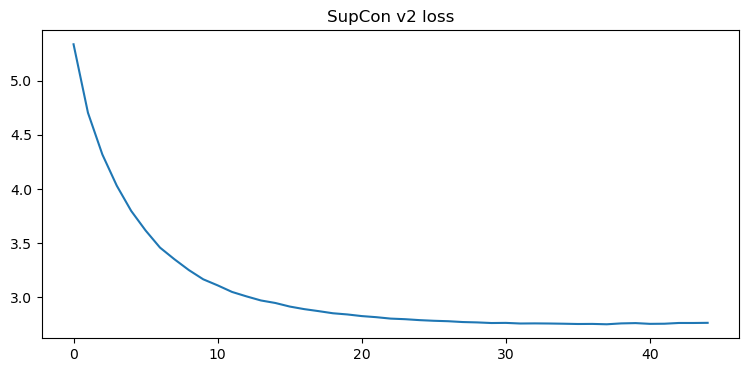

Feature dim: 480


In [8]:
# blocks = [
#     (64,   True,  False, True,  True),   # SE only
#     (128,  True,  False, True,  True),
#     (256,  True,  True,  True,  True),   # CBAM only here
#     (512,  True,  False, True,  True),
# ]
def build_backbone_expressive():
    return ShroomCNNAttentive(
        in_ch=3,
        block_cfgs=[
            (64,True, False,True,True),
            (128,True, False,True,True),
            (256,True, True, True,True),
            (320,True, False,True,True),
            (384, True, True, True, True),
        ],
        mlp_units=[1024, 512],
        num_classes=num_classes,     # ignored by EncoderFromBackbone
        global_pool="gem",
        width_mult=1.25
    )




enc_state_dict, feat_dim, proj_state_dict, hist = pretrain_contrastive_v2(
    build_backbone_expressive, cont_loader,
    epochs=45, lr=1e-3, weight_decay=1e-4,
    t0=0.15, t1=0.05,           # temperature schedule
    use_hier=True, gamma0=0.30, gamma1=0.40,
    aux_lambda0=0.05, aux_lambda1=0.18,
    species_to_genus=species_to_genus
)
plt.figure(figsize=(9,4)); plt.plot(hist); plt.title("SupCon v2 loss"); plt.show()

print("Feature dim:", feat_dim)

Encoding (val):   0%|          | 0/61 [00:09<?, ?it/s]

[encoder f] shape=(15616, 480)  N=15616
t-SNE (encoder f) on 7638 points...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7638 samples in 0.000s...
[t-SNE] Computed neighbors for 7638 samples in 0.194s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7638
[t-SNE] Computed conditional probabilities for sample 2000 / 7638
[t-SNE] Computed conditional probabilities for sample 3000 / 7638
[t-SNE] Computed conditional probabilities for sample 4000 / 7638
[t-SNE] Computed conditional probabilities for sample 5000 / 7638
[t-SNE] Computed conditional probabilities for sample 6000 / 7638
[t-SNE] Computed conditional probabilities for sample 7000 / 7638
[t-SNE] Computed conditional probabilities for sample 7638 / 7638
[t-SNE] Mean sigma: 1.770497
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.349220
[t-SNE] KL divergence after 1000 iterations: 1.151396


/Users/TommyLubomirski/anaconda3/envs/cpsc330/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/var/folders/jj/t84dzw752ynb90ssgn0q9d4w0000gp/T/ipykernel_5023/3930990455.py:135: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20')


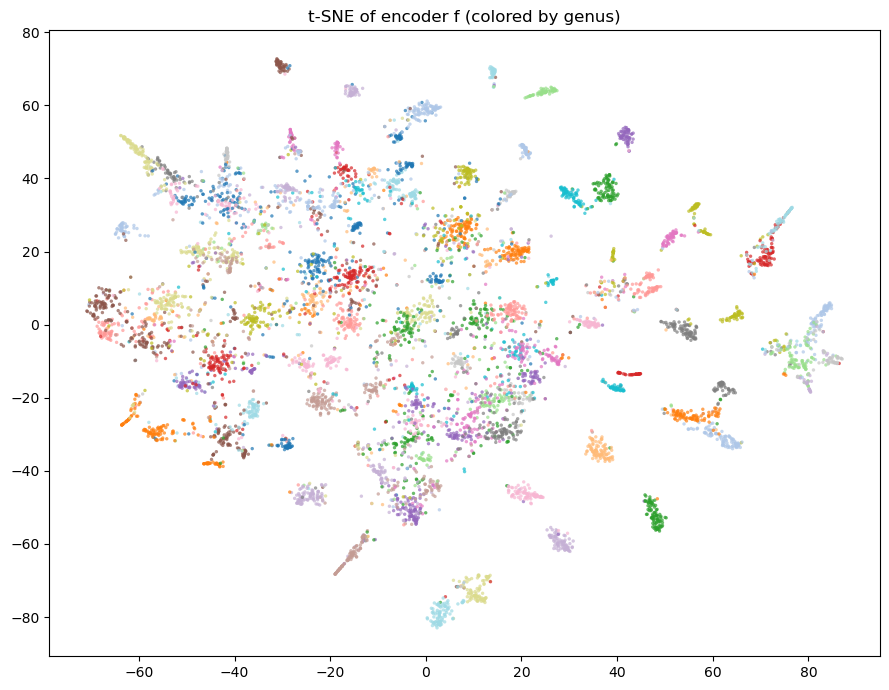

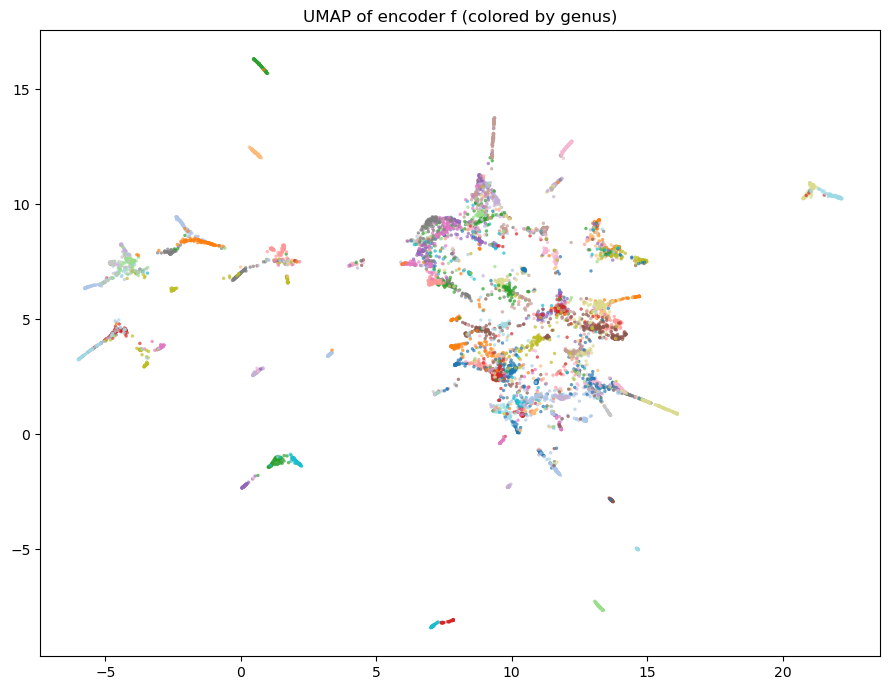

k-NN purity (k=10) on encoder f: species=0.639, genus=0.713


In [ ]:
# ===== Embed & visualize after pretrain_contrastive =====
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from torchvision.transforms import v2 as T
from torch.utils.data import DataLoader

# Rebuild the encoder for inference
device = get_device()

backbone = build_backbone_expressive()
enc_infer = EncoderFromBackbone(backbone)
enc_infer.load_state_dict(enc_state_dict, strict=True)
enc_infer.eval().to(device)
try:
    enc_infer = enc_infer.to(memory_format=torch.channels_last)
except Exception:
    pass
for p in enc_infer.parameters():
    p.requires_grad = False

USE_PROJECTOR = False  # set False to skip
if USE_PROJECTOR:
    projector_infer = ProjectionMLP(feat_dim).to(device).eval()
    projector_infer.load_state_dict(proj_state_dict, strict=True)
    projector_infer.apply(_bn_to_fp32)
else:
    projector_infer = None

# Deterministic eval transform (center crop), same size as pretrain crop
EVAL_SIZE = IMGc if "IMGc" in globals() else 196
mean = (0.485, 0.456, 0.406)
std  = (0.229, 0.224, 0.225)
eval_tf = T.Compose([
    T.Resize(EVAL_SIZE, antialias=True),
    T.CenterCrop(EVAL_SIZE),
    T.ToDtype(torch.float32, scale=True),
    T.Normalize(mean, std),
])

# Build a dataset/loader (use val set for speed/cleanliness)
# use the same label2idx as pretrain to keep species ids aligned.
eval_ds = ShroomDataset(val_meta, data_path, transform=eval_tf, label2idx=cont_base.label2idx)
NUM_WORKERS_EVAL = min(8, max(1, (os.cpu_count() or 4) // 2))
eval_loader = DataLoader(
    eval_ds, batch_size=256, shuffle=False,
    num_workers=NUM_WORKERS_EVAL, persistent_workers=(NUM_WORKERS_EVAL > 0),
    pin_memory=torch.cuda.is_available()
)

#  collect BOTH encoder f and projector z in one pass 
feat_enc_list, feat_proj_list = [], []
species_ids_list = []

with torch.no_grad():
    for x, y in tqdm(eval_loader, desc="Encoding (val)", leave=False):
        x = x.to(device, non_blocking=True).contiguous(memory_format=torch.channels_last)
        f = enc_infer(x)                          # [B, feat_dim]
        f = torch.nan_to_num(f, nan=0.0).float()
        feat_enc_list.append(f.cpu())
        species_ids_list.append(y)

        if projector_infer is not None:
            z = projector_infer(f)                # normalized by ProjectionMLP (if BN present)
            feat_proj_list.append(z.cpu())

# Stack arrays
emb_enc = torch.cat(feat_enc_list, dim=0).numpy()                         # [N, Df]
species_ids = torch.cat(species_ids_list, dim=0).numpy().astype(np.int64) # [N]
genus_ids = np.asarray([int(species_to_genus[s]) for s in species_ids], dtype=np.int64)

emb_proj = None
if projector_infer is not None and len(feat_proj_list) > 0:
    emb_proj = torch.cat(feat_proj_list, dim=0).numpy()                    # [N, Dz]

print(f"[encoder f] shape={emb_enc.shape}  N={emb_enc.shape[0]}")
if emb_proj is not None:
    print(f"[projector z] shape={emb_proj.shape}  N={emb_proj.shape[0]}")

#helper: reduce, plot, and compute k-NN purity for any embedding
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from inspect import signature

def reduce_plot_knn(emb, species_ids, genus_ids, name="embedding", max_tsne=10000):
    N, D = emb.shape
    # PCA to 50 dims
    MAX_PCA = min(90000, N)
    pca_idx = np.random.default_rng(0).choice(N, size=MAX_PCA, replace=False)
    pca = PCA(n_components=min(50, D), random_state=0)
    pca.fit(emb[pca_idx])
    X50 = pca.transform(emb)

    # stratified subsample for t-SNE
    if N > max_tsne:
        per_g = max(1, max_tsne // (genus_ids.max() + 1))
        idx_tsne = []
        rng = np.random.default_rng(1)
        for g in np.unique(genus_ids):
            g_idx = np.where(genus_ids == g)[0]
            take = min(len(g_idx), per_g)
            if take > 0:
                idx_tsne.append(rng.choice(g_idx, size=take, replace=False))
        idx_tsne = np.concatenate(idx_tsne) if len(idx_tsne) else np.arange(min(N, max_tsne))
    else:
        idx_tsne = np.arange(N)

    X50_sub = X50[idx_tsne]
    genus_sub = genus_ids[idx_tsne]

    # version-agnostic TSNE kwargs
    _tsne_kwargs = dict(n_components=2, init="pca", perplexity=30, random_state=0)
    sig = signature(TSNE.__init__)
    supp = set(sig.parameters.keys())
    if "learning_rate" in supp: _tsne_kwargs["learning_rate"] = "auto"
    if "n_iter" in supp:        _tsne_kwargs["n_iter"] = 1000
    if "verbose" in supp:       _tsne_kwargs["verbose"] = 1

    print(f"t-SNE ({name}) on {len(idx_tsne)} points...")
    XY = TSNE(**_tsne_kwargs).fit_transform(X50_sub)

    # UMAP if available
    HAVE_UMAP = False
    try:
        import umap.umap_ as umap
        XY_umap = umap.UMAP(n_components=2, n_neighbors=35, min_dist=0.1, random_state=0).fit_transform(X50_sub)
        HAVE_UMAP = True
    except Exception:
        pass

    # plots
    cmap = plt.cm.get_cmap('tab20')
    colors = [cmap((g % 20) / 20.0) for g in genus_sub]

    plt.figure(figsize=(9,7))
    plt.scatter(XY[:,0], XY[:,1], c=colors, s=6, alpha=0.7, linewidths=0)
    plt.title(f"t-SNE of {name} (colored by genus)")
    plt.tight_layout(); plt.show()

    if HAVE_UMAP:
        plt.figure(figsize=(9,7))
        plt.scatter(XY_umap[:,0], XY_umap[:,1], c=colors, s=6, alpha=0.7, linewidths=0)
        plt.title(f"UMAP of {name} (colored by genus)")
        plt.tight_layout(); plt.show()

    # k-NN purity
    k = 10
    nn = NearestNeighbors(n_neighbors=k+1, algorithm="auto", n_jobs=-1)
    nn.fit(emb)
    _, nbrs = nn.kneighbors(emb, return_distance=True)
    nbrs = nbrs[:,1:]  # drop self
    sp_match = (species_ids[nbrs] == species_ids[:,None]).mean()
    gn_match = (genus_ids[nbrs]   == genus_ids[:,None]).mean()
    print(f"k-NN purity (k={k}) on {name}: species={sp_match:.3f}, genus={gn_match:.3f}")

# Run for encoder f
reduce_plot_knn(emb_enc, species_ids, genus_ids, name="encoder f")

# Run for projector z (if present)
if emb_proj is not None:
    reduce_plot_knn(emb_proj, species_ids, genus_ids, name="projector z")

In [10]:
def one_nn_accuracy(emb, labels):
    nn = NearestNeighbors(n_neighbors=2, algorithm="auto", n_jobs=-1)  # self + 1 neighbor
    nn.fit(emb)
    _, nbrs = nn.kneighbors(emb, return_distance=True)
    pred = labels[nbrs[:,1]]  # neighbor label
    acc = (pred == labels).mean()
    return float(acc)

print("1-NN (encoder f) species acc:", f"{one_nn_accuracy(emb_enc, species_ids):.3f}")
if emb_proj is not None:
    print("1-NN (projector z) species acc:", f"{one_nn_accuracy(emb_proj, species_ids):.3f}")

import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from collections import defaultdict

def l2_normalize(a, eps=1e-8):
    n = np.linalg.norm(a, axis=1, keepdims=True)
    return a / np.clip(n, eps, None)

def knn_purity(emb, y_sp, y_gn, k=10, metric='cosine'):
    nn = NearestNeighbors(n_neighbors=k+1, metric=metric, algorithm='auto', n_jobs=-1)
    nn.fit(emb)
    _, nbrs = nn.kneighbors(emb, return_distance=True)  # includes self
    nbrs = nbrs[:,1:]  # drop self
    sp_match = (y_sp[nbrs] == y_sp[:,None]).mean()
    gn_match = (y_gn[nbrs] == y_gn[:,None]).mean()
    return float(sp_match), float(gn_match)

def one_nn_acc(emb, y_sp, metric='cosine'):
    nn = NearestNeighbors(n_neighbors=2, metric=metric, algorithm='auto', n_jobs=-1)
    nn.fit(emb)
    _, nbrs = nn.kneighbors(emb, return_distance=True)
    pred = y_sp[nbrs[:,1]]
    top1 = (pred == y_sp).mean()
    return float(top1), pred

def nearest_class_mean(emb, y_sp, y_gn, normalize=True):
    # compute centroids per species; predict by nearest centroid (cosine)
    X = l2_normalize(emb) if normalize else emb
    centroids = {}
    for sp in np.unique(y_sp):
        centroids[sp] = X[y_sp == sp].mean(axis=0)
        if normalize:
            c = centroids[sp]
            centroids[sp] = c / (np.linalg.norm(c) + 1e-8)
    C = np.stack([centroids[sp] for sp in sorted(centroids.keys())], axis=0)
    species_list = np.array(sorted(centroids.keys()), dtype=np.int64)

    # cosine sim → argmax
    Xn = l2_normalize(X) if not normalize else X
    sims = Xn @ C.T
    pred_sp = species_list[np.argmax(sims, axis=1)]

    # species acc
    sp_acc = (pred_sp == y_sp).mean()

    # genus acc (from predicted species)
    pred_gn = np.asarray([int(species_to_genus[s]) for s in pred_sp], dtype=np.int64)
    gn_acc = (pred_gn == y_gn).mean()
    return float(sp_acc), float(gn_acc)

def report_all(name, emb, y_sp, y_gn, do_pca_whiten=True):
    print(f"\n=== {name} ({emb.shape[0]}×{emb.shape[1]}) ===")

    # unnormalized & L2-normalized views
    emb_l2 = l2_normalize(emb)

    for metric in ['cosine', 'euclidean']:
        t1, _ = one_nn_acc(emb_l2 if metric=='euclidean' else emb, y_sp, metric=metric)
        sp5, gn5  = knn_purity(emb_l2 if metric=='euclidean' else emb, y_sp, y_gn, k=5,  metric=metric)
        sp10, gn10= knn_purity(emb_l2 if metric=='euclidean' else emb, y_sp, y_gn, k=10, metric=metric)
        print(f"[{metric}] 1-NN species={t1:.3f} | k=5: sp={sp5:.3f}, gn={gn5:.3f} | k=10: sp={sp10:.3f}, gn={gn10:.3f}")

    # PCA-whiten → Euclidean (common trick for k-NN on embeddings)
    if do_pca_whiten:
        d = min(128, emb.shape[1])  # 64/128 are typical
        pca = PCA(n_components=d, whiten=True, random_state=0)
        Xw  = pca.fit_transform(emb)
        t1w,_ = one_nn_acc(Xw, y_sp, metric='euclidean')
        sp5w, gn5w   = knn_purity(Xw, y_sp, y_gn, k=5,  metric='euclidean')
        sp10w, gn10w = knn_purity(Xw, y_sp, y_gn, k=10, metric='euclidean')
        print(f"[PCA{d}-whiten+euclid] 1-NN species={t1w:.3f} | k=5: sp={sp5w:.3f}, gn={gn5w:.3f} | k=10: sp={sp10w:.3f}, gn={gn10w:.3f}")

    # Nearest-class-mean (cosine)
    sp_acc, gn_acc = nearest_class_mean(emb, y_sp, y_gn, normalize=True)
    print(f"[NCM cosine] species={sp_acc:.3f} | genus={gn_acc:.3f}")

# Run for encoder f
report_all("encoder f", emb_enc, species_ids, genus_ids)

# Run for projector z (if available)
if emb_proj is not None:
    report_all("projector z", emb_proj, species_ids, genus_ids)

1-NN (encoder f) species acc: 0.672

=== encoder f (15616×480) ===
[cosine] 1-NN species=0.680 | k=5: sp=0.661, gn=0.731 | k=10: sp=0.651, gn=0.723
[euclidean] 1-NN species=0.680 | k=5: sp=0.661, gn=0.731 | k=10: sp=0.651, gn=0.723
[PCA128-whiten+euclid] 1-NN species=0.663 | k=5: sp=0.642, gn=0.707 | k=10: sp=0.627, gn=0.693
[NCM cosine] species=0.719 | genus=0.773


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, trustworthiness
from sklearn.neighbors import NearestNeighbors

# =========================
# Utilities
# =========================
def rng(seed=0):
    return np.random.default_rng(seed)

def l2_normalize(a, eps=1e-8):
    n = np.linalg.norm(a, axis=1, keepdims=True)
    return a / np.clip(n, eps, None)

def invert_label2idx(label2idx):
    return {v:k for k,v in label2idx.items()}

def most_frequent_labels(y, top_n=30):
    cnt = Counter(y.tolist())
    return [lab for lab,_ in cnt.most_common(top_n)]

def stratified_subsample(y, per_class=None, max_total=None, seed=0):
    """
    Return indices for a stratified subsample by labels y (int array).
    - per_class: cap per label
    - max_total: global cap (applied after per_class)
    """
    y = np.asarray(y)
    idxs = []
    R = rng(seed)
    for c in np.unique(y):
        ids = np.where(y == c)[0]
        take = len(ids) if per_class is None else min(per_class, len(ids))
        if take > 0:
            idxs.append(R.choice(ids, size=take, replace=False))
    idxs = np.concatenate(idxs) if len(idxs) else np.arange(0)
    if max_total is not None and len(idxs) > max_total:
        idxs = R.choice(idxs, size=max_total, replace=False)
    return np.sort(idxs)

def build_palette(labels, names=None):
    """
    Returns:
      color_map: dict {label -> RGBA}
      name_map : dict {label -> string name}
    Uses a stable HSV hashing when #classes is large.
    """
    labs = np.unique(labels)
    name_map = {lab: (names[lab] if names is not None else str(lab)) for lab in labs}

    # Up to 20 → tab20; else use evenly spaced HSV (stable across runs)
    if len(labs) <= 20:
        cmap = plt.cm.get_cmap('tab20', len(labs))
        color_map = {lab: cmap(i) for i, lab in enumerate(labs)}
    else:
        # stable hues by sorting labels
        labs_sorted = np.sort(labs)
        color_map = {}
        for i, lab in enumerate(labs_sorted):
            h = i / len(labs_sorted)
            color_map[lab] = plt.cm.hsv(h)
    return color_map, name_map

def legend_for_topN(ax, labels, names, color_map, top_n=25, loc='center left', bbox_to_anchor=(1.02, 0.5)):
    top = most_frequent_labels(labels, top_n=top_n)
    handles = []
    for lab in top:
        handles.append(plt.Line2D([0],[0], marker='o', linestyle='',
                                  color=color_map[lab], label=names[lab], markersize=6))
    leg = ax.legend(handles=handles, title=f"Top-{len(handles)} species", loc=loc, bbox_to_anchor=bbox_to_anchor)
    ax.add_artist(leg)
    return leg

# =========================
# Dimensionality reduction + plots
# =========================
def reduce_pca(X, n_components=50, whiten=False, seed=0, fit_on_subset=100_000):
    N = X.shape[0]
    pca = PCA(n_components=min(n_components, X.shape[1]), whiten=whiten, random_state=seed)
    if N > fit_on_subset:
        idx = rng(seed).choice(N, size=fit_on_subset, replace=False)
        pca.fit(X[idx])
    else:
        pca.fit(X)
    return pca, pca.transform(X)

def tsne_embed(X50, y, perplexity=None, n_iter=1500, seed=0, verbose=1):
    N = X50.shape[0]
    # rule of thumb: perplexity ≈ min(30, (N-1)/3) lower bounded by 5
    if perplexity is None:
        perplexity = int(np.clip(30, 5, (N - 1) // 3)) if N >= 100 else max(5, N // 4)
    tsne = TSNE(n_components=2, init='pca', perplexity=perplexity,
                learning_rate='auto', max_iter=n_iter, random_state=seed, verbose=verbose)
    XY = tsne.fit_transform(X50)
    tw = trustworthiness(X50, XY, n_neighbors=10)
    return XY, tw

def umap_embed(X50, n_neighbors=35, min_dist=0.1, seed=0):
    try:
        import umap.umap_ as umap
        reducer = umap.UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=min_dist, random_state=seed)
        XY = reducer.fit_transform(X50)
        # trustworthiness against X50 for apples-to-apples
        tw = trustworthiness(X50, XY, n_neighbors=10)
        return XY, tw
    except Exception as e:
        print("[UMAP] not available:", e)
        return None, None

def plot_embedding(XY, y, names=None, title="Embedding", top_n_legend=25, s=5, alpha=0.7):
    colors, name_map = build_palette(y, names)
    col = np.array([colors[lab] for lab in y])
    fig, ax = plt.subplots(figsize=(9.5, 7.5))
    ax.scatter(XY[:,0], XY[:,1], c=col, s=s, alpha=alpha, linewidths=0)
    ax.set_title(title)
    ax.set_xticks([]); ax.set_yticks([])
    legend_for_topN(ax, y, name_map, colors, top_n=top_n_legend)
    fig.tight_layout()
    plt.show()

def pca_tsne_umap_plots(emb, y_species, idx2species=None,
                        per_class=200, max_total=25_000, seed=0,
                        whiten_for_knn=False, title_prefix=""):
    # 1) stratified subsample (more points but balanced)
    idx = stratified_subsample(y_species, per_class=per_class, max_total=max_total, seed=seed)
    X = emb[idx]
    y = y_species[idx]
    names = None
    if idx2species is not None:
        # map id -> readable label array
        max_id = int(np.max(y_species))
        name_list = [idx2species.get(i, str(i)) for i in range(max_id+1)]
        names = np.array(name_list, dtype=object)

    # 2) PCA→50
    pca, X50 = reduce_pca(X, n_components=50, whiten=False, seed=seed)

    # 3) t-SNE
    XY_tsne, tw_tsne = tsne_embed(X50, y, perplexity=None, n_iter=1500, seed=seed, verbose=1)
    plot_embedding(XY_tsne, y, names=names, title=f"{title_prefix} t-SNE (species color)", top_n_legend=25)
    print(f"[t-SNE] N={len(y)} | trustworthiness@10 = {tw_tsne:.3f}")

    # 4) UMAP (if available)
    XY_umap, tw_umap = umap_embed(X50, n_neighbors=35, min_dist=0.1, seed=seed)
    if XY_umap is not None:
        plot_embedding(XY_umap, y, names=names, title=f"{title_prefix} UMAP (species color)", top_n_legend=25)
        print(f"[UMAP] N={len(y)} | trustworthiness@10 = {tw_umap:.3f}")

    return {"idx": idx, "pca": pca, "X50": X50, "tsne": XY_tsne, "umap": XY_umap}

# =========================
# kNN / 1-NN metrics
# =========================
def knn_purity(emb, y, k=10, metric='cosine', normalize_for_cosine=True):
    X = emb
    if metric == 'cosine' and normalize_for_cosine:
        X = l2_normalize(X)
    nn = NearestNeighbors(n_neighbors=k+1, metric=metric, algorithm='auto', n_jobs=-1)
    nn.fit(X)
    _, nbrs = nn.kneighbors(X, return_distance=True)
    nbrs = nbrs[:,1:]
    purity = (y[nbrs] == y[:,None]).mean()
    return float(purity)

def one_nn_acc(emb, y, metric='cosine', normalize_for_cosine=True):
    X = emb
    if metric == 'cosine' and normalize_for_cosine:
        X = l2_normalize(X)
    nn = NearestNeighbors(n_neighbors=2, metric=metric, algorithm='auto', n_jobs=-1)
    nn.fit(X)
    _, nbrs = nn.kneighbors(X, return_distance=True)
    pred = y[nbrs[:,1]]
    acc = (pred == y).mean()
    return float(acc), pred

def pca_whiten(emb, d=128, seed=0):
    p = PCA(n_components=min(d, emb.shape[1]), whiten=True, random_state=seed)
    return p.fit_transform(emb)

def nearest_class_mean(emb, y, normalize=True):
    X = l2_normalize(emb) if normalize else emb
    centroids = {}
    for c in np.unique(y):
        centroids[c] = X[y==c].mean(axis=0)
        if normalize:
            centroids[c] /= (np.linalg.norm(centroids[c]) + 1e-8)
    classes = np.array(sorted(centroids.keys()))
    C = np.stack([centroids[c] for c in classes], axis=0)
    Xq = X if normalize else l2_normalize(X)
    pred = classes[np.argmax(Xq @ C.T, axis=1)]
    acc = (pred == y).mean()
    return float(acc), pred

def one_nn_confusion(emb, y, idx2name=None, top_n=30, metric='cosine'):
    acc, pred = one_nn_acc(emb, y, metric=metric, normalize_for_cosine=True)
    # restrict to top-N frequent classes for readability
    top = most_frequent_labels(y, top_n)
    top_set = set(top)
    mask = np.array([yi in top_set for yi in y])
    y_top   = y[mask]
    pred_top= pred[mask]
    labs = sorted(top)
    lab2i = {lab:i for i,lab in enumerate(labs)}
    C = np.zeros((len(labs), len(labs)), dtype=int)
    for yt, pt in zip(y_top, pred_top):
        if yt in lab2i and pt in lab2i:
            C[lab2i[yt], lab2i[pt]] += 1
    # normalize rows
    row_sums = C.sum(axis=1, keepdims=True).clip(min=1)
    Cn = C / row_sums

    fig, ax = plt.subplots(figsize=(min(12, 0.35*len(labs)+4), min(10, 0.35*len(labs)+3)))
    im = ax.imshow(Cn, aspect='auto', interpolation='nearest')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.set_title(f"1-NN confusion (top-{len(labs)}) • acc={acc:.3f}")
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")

    def label_for(i):
        if idx2name is None: return str(i)
        return idx2name.get(i, str(i))

    ax.set_xticks(range(len(labs))); ax.set_yticks(range(len(labs)))
    ax.set_xticklabels([label_for(i) for i in labs], rotation=90, fontsize=8)
    ax.set_yticklabels([label_for(i) for i in labs], fontsize=8)
    fig.tight_layout(); plt.show()
    return acc

def knn_suite_report(name, emb, y_sp, y_gn=None, seed=0):
    print(f"\n=== {name}  N={emb.shape[0]}  D={emb.shape[1]} ===")

    # Raw (cosine) + Euclidean
    acc1_cos, _ = one_nn_acc(emb, y_sp, metric='cosine')
    sp5_cos = knn_purity(emb, y_sp, k=5, metric='cosine')
    sp10_cos = knn_purity(emb, y_sp, k=10, metric='cosine')
    print(f"[cosine] 1-NN species={acc1_cos:.3f} | purity@5={sp5_cos:.3f} | purity@10={sp10_cos:.3f}")

    acc1_euc, _ = one_nn_acc(emb, y_sp, metric='euclidean', normalize_for_cosine=False)
    sp5_euc = knn_purity(emb, y_sp, k=5, metric='euclidean', normalize_for_cosine=False)
    sp10_euc = knn_purity(emb, y_sp, k=10, metric='euclidean', normalize_for_cosine=False)
    print(f"[euclid] 1-NN species={acc1_euc:.3f} | purity@5={sp5_euc:.3f} | purity@10={sp10_euc:.3f}")

    # PCA-whiten → Euclidean (strong baseline)
    Xw = pca_whiten(emb, d=min(128, emb.shape[1]), seed=seed)
    acc1_w, _ = one_nn_acc(Xw, y_sp, metric='euclidean', normalize_for_cosine=False)
    sp5_w = knn_purity(Xw, y_sp, k=5, metric='euclidean', normalize_for_cosine=False)
    sp10_w = knn_purity(Xw, y_sp, k=10, metric='euclidean', normalize_for_cosine=False)
    print(f"[PCA-whiten+euclid] 1-NN species={acc1_w:.3f} | purity@5={sp5_w:.3f} | purity@10={sp10_w:.3f}")

    # NCM (cosine)
    ncm_sp, _ = nearest_class_mean(emb, y_sp, normalize=True)
    print(f"[NCM cosine] species={ncm_sp:.3f}")

    if y_gn is not None:
        sp5_gn = knn_purity(emb, y_gn, k=5, metric='cosine')
        sp10_gn = knn_purity(emb, y_gn, k=10, metric='cosine')
        print(f"[cosine] genus purity@5={sp5_gn:.3f} | purity@10={sp10_gn:.3f}")

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 13820 samples in 0.000s...
[t-SNE] Computed neighbors for 13820 samples in 0.163s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13820
[t-SNE] Computed conditional probabilities for sample 2000 / 13820
[t-SNE] Computed conditional probabilities for sample 3000 / 13820
[t-SNE] Computed conditional probabilities for sample 4000 / 13820
[t-SNE] Computed conditional probabilities for sample 5000 / 13820
[t-SNE] Computed conditional probabilities for sample 6000 / 13820
[t-SNE] Computed conditional probabilities for sample 7000 / 13820
[t-SNE] Computed conditional probabilities for sample 8000 / 13820
[t-SNE] Computed conditional probabilities for sample 9000 / 13820
[t-SNE] Computed conditional probabilities for sample 10000 / 13820
[t-SNE] Computed conditional probabilities for sample 11000 / 13820
[t-SNE] Computed conditional probabilities for sample 12000 / 13820
[t-SNE] Computed conditional probabilities for sam

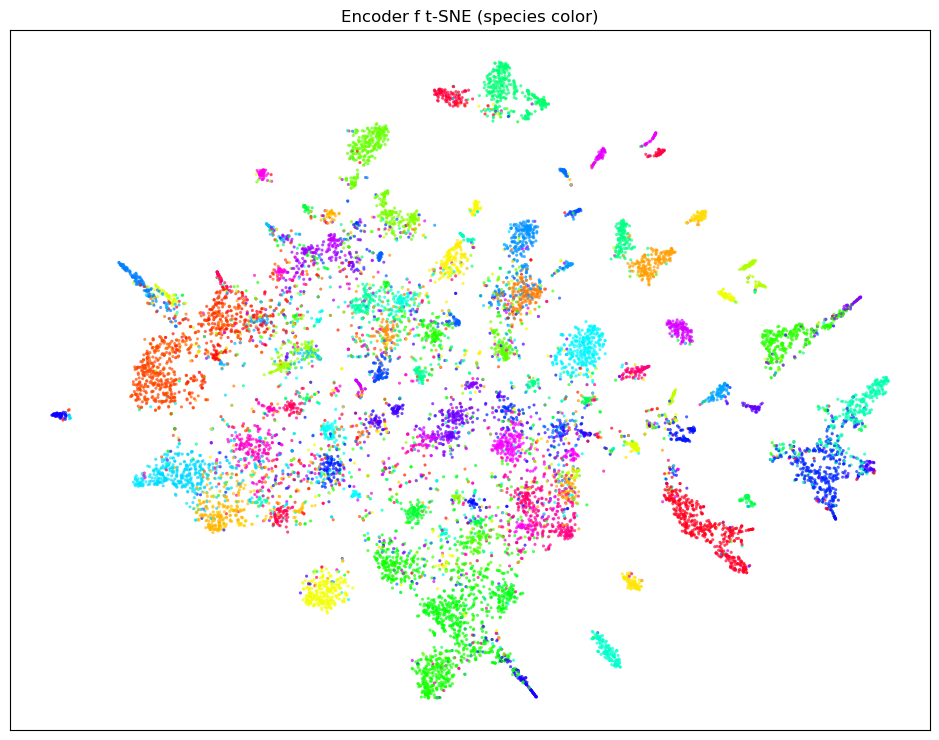

[t-SNE] N=13820 | trustworthiness@10 = 0.993


/Users/TommyLubomirski/anaconda3/envs/cpsc330/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


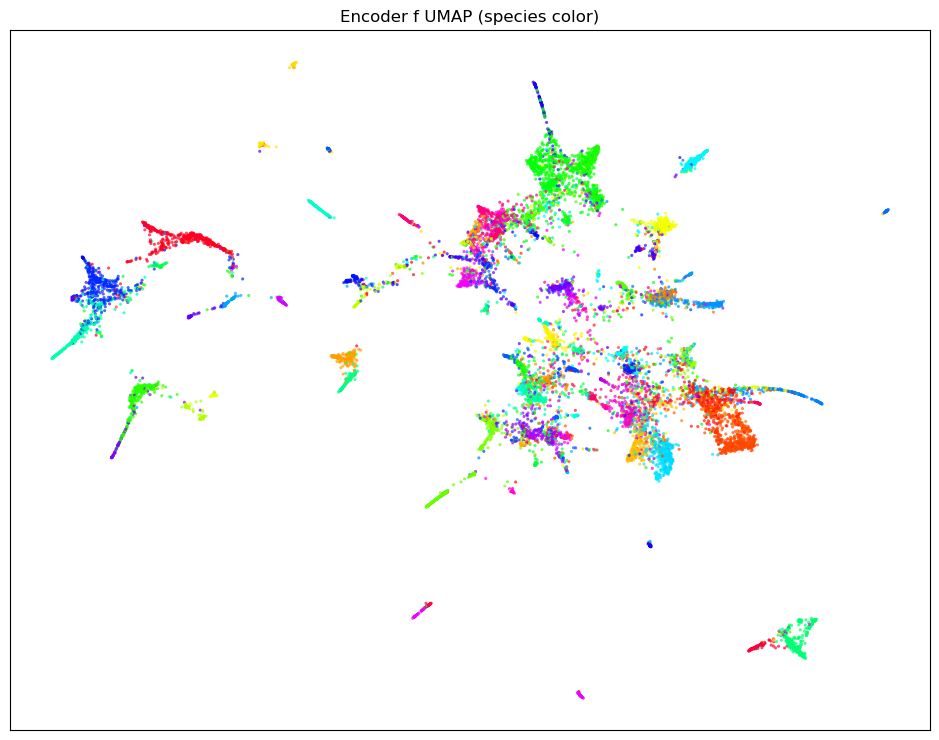

[UMAP] N=13820 | trustworthiness@10 = 0.983

=== encoder f  N=15616  D=480 ===
[cosine] 1-NN species=0.680 | purity@5=0.661 | purity@10=0.651
[euclid] 1-NN species=0.672 | purity@5=0.652 | purity@10=0.639
[PCA-whiten+euclid] 1-NN species=0.663 | purity@5=0.642 | purity@10=0.627
[NCM cosine] species=0.719
[cosine] genus purity@5=0.731 | purity@10=0.723


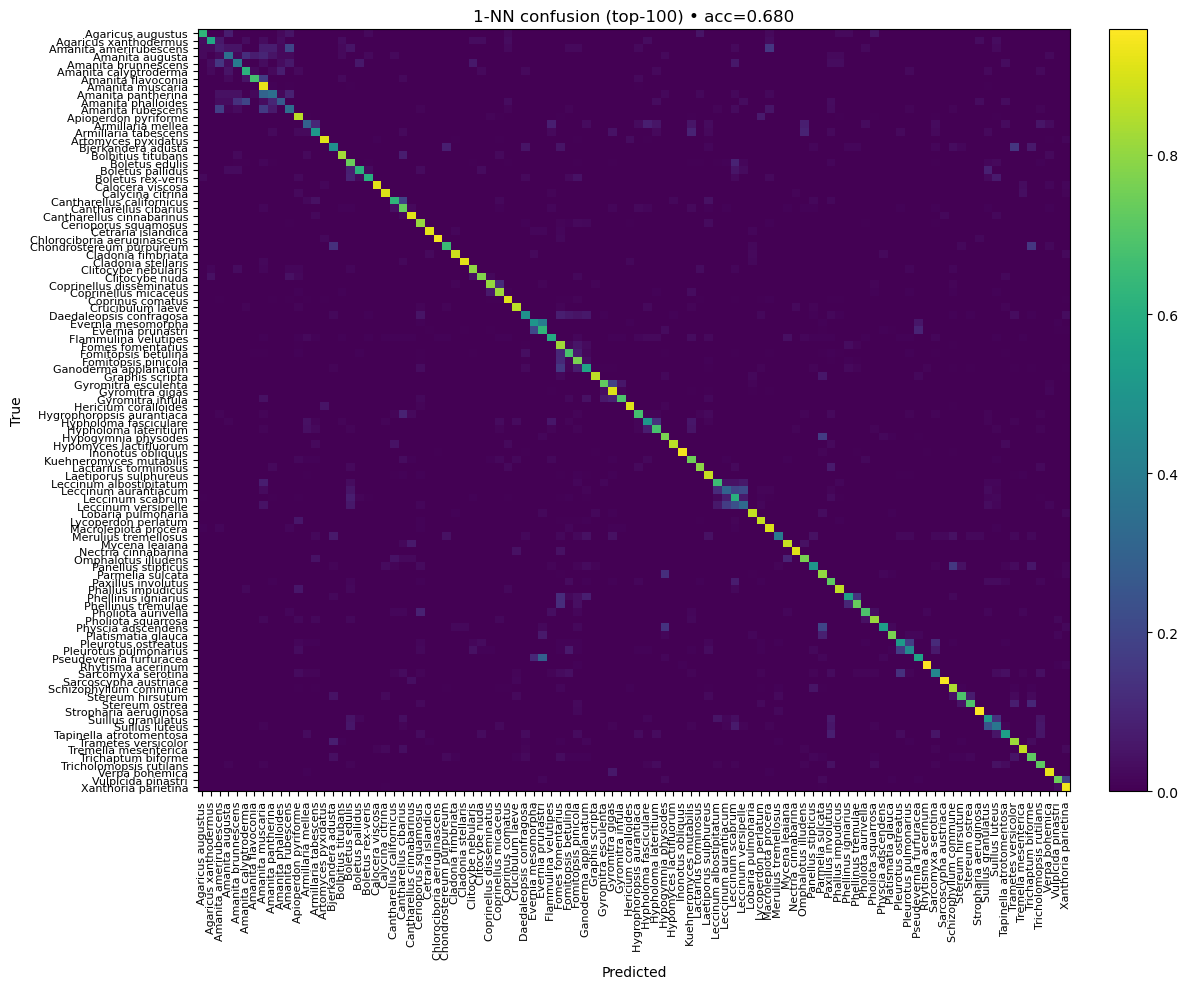

In [15]:
# 0) Optional: readable species names
# You had cont_base.label2idx; invert it to map id -> species string
idx2species = invert_label2idx(cont_base.label2idx)  # {'amerob': 0, ...} -> {0:'amerob', ...}

# 1) Visualize encoder features (species color, bigger/balanced sample)
viz = pca_tsne_umap_plots(
    emb_enc, species_ids, idx2species=idx2species,
    per_class=350,         # upsample per species for visibility
    max_total=70_000,      # cap for speed; raise if you can afford it
    seed=0,
    title_prefix="Encoder f"
)

# 2) kNN / 1-NN suite + confusion on top species
knn_suite_report("encoder f", emb_enc, species_ids, y_gn=genus_ids, seed=0)
_ = one_nn_confusion(emb_enc, species_ids, idx2name=idx2species, top_n=100, metric='cosine')

# 3) (Optional) Do the same for projector z if you used it
if emb_proj is not None:
    viz_z = pca_tsne_umap_plots(
        emb_proj, species_ids, idx2species=idx2species,
        per_class=350, max_total=70_000, seed=0, title_prefix="Projector z"
    )
    knn_suite_report("projector z", emb_proj, species_ids, y_gn=genus_ids, seed=0)
    _ = one_nn_confusion(emb_proj, species_ids, idx2name=idx2species, top_n=100, metric='cosine')